In [110]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.decomposition import FactorAnalysis, PCA


In [2]:
#build toy dataset
def generate_samples_gauss(n_samples_class):
    cov = np.array([[10, 2], [2, 1]])
    mean1 = np.array([0, 0])
    mean2 = np.array([0, 5])

    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 2))

    x[:n_samples_class, 0], x[:n_samples_class, 1] = np.random.multivariate_normal(mean1, cov, n_samples_class).T
    x[n_samples_class:, 0], x[n_samples_class:, 1]  = np.random.multivariate_normal(mean2, cov, n_samples_class).T

    labels = np.zeros(total_n_samples)
    labels[n_samples_class:] = 1
    return x, labels

In [3]:
def generate_samples_uniform(n_samples_class):
    x[:,0] = np.random.rand(2*n_samples_class)
    x[n_samples_class:,1] = x[n_samples_class:,0] + 0.1
    x[:n_samples_class,1] = x[:n_samples_class,0] - 0.1
    
    labels = np.zeros(2*n_samples_class)
    labels[n_samples_class:] = 1
    return x, labels


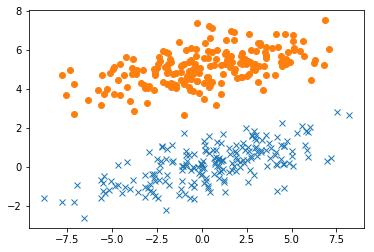

In [85]:
n_samples_class = 200
x, y  =  generate_samples_gauss(n_samples_class)
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')

#plt.savefig("data_2d.png")
plt.show()

In [5]:
latent_dim = 1 #suppose z is scalar
x_dim = 2      
size_f = latent_dim*x_dim

params_size_logit_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim + 1
params_size_norm_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim
params_size_logit_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim + 1
params_size_norm_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim 

In [86]:
opt = "ppca"

if (opt == "fa"):
    params_size = params_size_logit_fa
else:
    params_size = params_size_logit_ppca
    


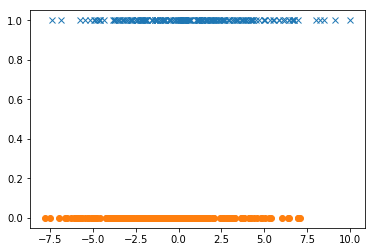

In [157]:
params = np.random.rand(params_size)

size_f = latent_dim*x_dim
var_init = params[size_f+x_dim:size_f+x_dim*2]

transformer = PCA(n_components="mle")
#transformer = FactorAnalysis(n_components=1, random_state=0)
x_proj_fa_python = transformer.fit_transform(x)
f_fa_python = transformer.components_
plt.plot(x_proj_fa_python[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_python[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.savefig('data_proj_fa_python')
plt.show()

6.589725809541786

In [142]:
f_sklearn = transformer.components_.T
cov_noise_sklearn = np.diag(np.ones(x_dim)*transformer.noise_variance_)
bias_sklearn = np.mean(x, axis =0)

def compute_ll(f,bias,cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2
    ll += log_det_cov_x*N/2
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    return -ll

compute_ll(f_sklearn, bias_sklearn, cov_noise_sklearn, x)

-2000.8761731802435

In [91]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior
    return ll 


def objective_norm (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    sigma = 1 # variance for the noise in y
    N = x.shape[0]
    D = x.shape[1]
    f, bias, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.einsum("dl,dm->lm", f, np.linalg.solve(cov_x,f)) #in fact m=l <- latent dimension 
    cov_z = np.identity(latent_dim) - temp1

    var_y = np.dot(w,np.dot(cov_z,w)) + sigma**2
    
    ll = N*D*np.log(2*np.pi)/2+(log_det_cov_x + lambda_e*np.log(var_y))*N*0.5
    
    temp2 = np.linalg.solve(cov_x, (x - bias).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias, temp2)
    mean_z = np.einsum("dl,dn->nl", f, temp2)
    mean_y = np.einsum("l,nl->n", w, mean_z)
    unnorm_log_pdf_y = (y - mean_y)**2/var_y
    ll = ll + 0.5*(np.sum(unnorm_log_pdf_x) + lambda_e*np.sum(unnorm_log_pdf_y))
    
    log_prior = 0 #f,bias,cov_noise and m for regularization use gaussian priors later
    ll = ll - log_prior
    return ll

def decode_parameters(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise= np.diag(np.log(1+np.exp(var)))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def transform(f, bias, cov_noise, x):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    return mean_z

In [92]:
f, bias, cov_noise, w =  decode_parameters(params, x_dim, latent_dim, opt)
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "bias: ", bias
print "cov_noise matrix: ", cov_noise
print "bias for y:\n", w[0]
print "logistic regression weights:\n", w[1:]
print "initial obj value logit", objective_logit(params, x, y, latent_dim, 0, opt)
#print "initial obj value norm", objective_norm(params, x, y, latent_dim, 0, opt)

Initial parameters
F: [[0.30154009]
 [0.44043306]]
slope [1.46061194]
bias:  [0.78957782 0.52086446]
cov_noise matrix:  [[1.04097678 0.        ]
 [0.         1.04097678]]
bias for y:
0.6416317576226847
logistic regression weights:
[0.00346302]
initial obj value logit 4531.5366792649065


In [192]:
lambda_e = 0
#run minimizer use ADAM instead?
def pcallback(params):
    f, bias, cov_noise, w = decode_parameters(params, x_dim, latent_dim, opt)
    print compute_ll(f, bias, cov_noise, x)
    
grad_objective_logit = grad(objective_logit, argnum = 0)
params_optimizied_logit, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_e, opt), callback= pcallback, pgtol = 1e-2)
f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
print "Final parameters_logit"
print "logit slope\n", f_logit[1]/f_logit[0]
print "F:\n", f_logit
print "bias for x:\n", bias_logit
print "cov_noise matrix:\n", cov_noise_logit
print "bias for y:\n", w_logit[0]
print "logistic regression weights:\n", w_logit[1:]
print "final objective value:\n", obj_value_logit

-2616.031025907683
-2338.2130500172884
-2133.0932163816624
-2040.2053977129933
-2007.0226689565668
-1994.9149126293028
-1989.279007135075
-1988.9086364116934
-1987.1283332739317
-1987.0800709610614
-1987.0769826329113
-1987.0767778292673
-1987.0766839866837
Final parameters_logit
logit slope
[0.35774374]
F:
[[1.92843665]
 [0.68988615]]
bias for x:
[0.32248984 2.59949478]
cov_noise matrix:
[[6.57306217 0.        ]
 [0.         6.57306217]]
bias for y:
0.29101558716935183
logistic regression weights:
[0.19738516]
final objective value:
1987.0766839866837


In [144]:
print "F scikit-learn\n", f_sklearn 
print "mean of x \n", bias_sklearn 
print "cov noise scikit-learn\n", cov_noise_sklearn 
#print transformer.loglike_

F scikit-learn
[[-0.94157068]
 [-0.33681546]]
mean of x 
[0.32263999 2.59954973]
cov noise scikit-learn
[[6.58972581 0.        ]
 [0.         6.58972581]]


In [124]:
print (np.einsum("dl,ml->dm",f_sklearn ,f_sklearn ) + cov_noise_sklearn)
print (np.einsum("dl,ml->dm",f_logit,f_logit) + cov_noise_logit)

[[7.47628116 0.31713556]
 [0.31713556 6.70317046]]
[[10.29245894  1.33047851]
 [ 1.33047851  7.04905351]]


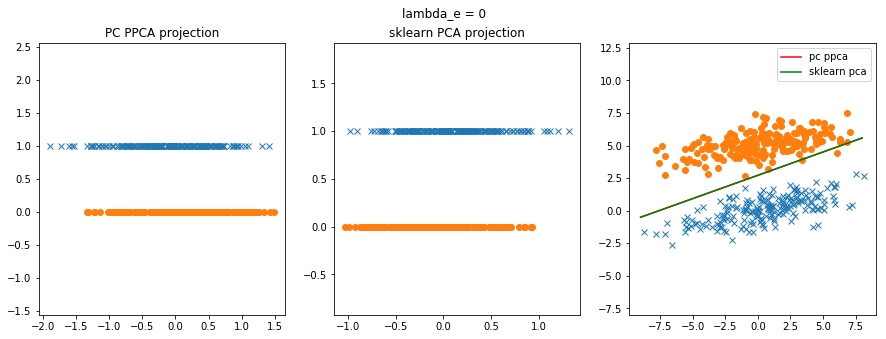

In [197]:
plt.figure(figsize=(15,5))

plt.subplot(131) 
plt.axis('equal')

plt.suptitle("lambda_e = {}".format(lambda_e))

plt.title("PC PPCA projection")
x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
plt.plot(x_proj_logit[:n_samples_class], np.ones(n_samples_class), 'x')
plt.plot(x_proj_logit[n_samples_class:], np.zeros(n_samples_class), 'o')

plt.subplot(132) 
plt.axis('equal')

plt.title("sklearn PCA projection")
x_proj_sklearn = transform(f_sklearn, bias_sklearn, cov_noise_sklearn, x)

plt.plot(x_proj_sklearn[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_sklearn[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.subplot(133) 
plt.axis('equal')
plt.plot(x[:n_samples_class,0], x[:n_samples_class,1], 'x')
plt.plot(x[n_samples_class:,0], x[n_samples_class:,1], 'o')
a_pc_fa_logit = np.array(range(int(round(np.min(x[:,0])))/1, (1+int(round(np.max(x[:,0])))/1))) 
a_sklearn = np.array(range(int(round(np.min(x[:,0]))), 1+int(round(np.max(x[:,0])))))

b_pc_fa_logit = f_logit[1]/f_logit[0]*(a_pc_fa_logit + bias_logit[0]) + bias_logit[1]
b_sklearn = f_sklearn[1]/f_sklearn[0]*(a_sklearn + bias_sklearn [0]) + bias_sklearn [1]

plt.plot(a_pc_fa_logit, b_pc_fa_logit,  color ="r", label='pc ppca')
plt.plot(a_sklearn, b_sklearn, color ="g", label='sklearn pca')

plt.legend()

plt.savefig("data_lambda_e={}_logistic_pc_ppca_vs_sklearn_pca.png".format(lambda_e))
plt.show()

In [106]:
from sklearn.linear_model import LogisticRegression
clf_fa = LogisticRegression().fit(x_proj_fa_python, y)
clf_fa.score(x_proj_fa_python, y)

/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5175

In [107]:
clf_pc = LogisticRegression().fit(x_proj_logit, y)
clf_pc.score(x_proj_logit, y)

1.0

In [108]:
clf = LogisticRegression().fit(x, y)
clf.score(x, y)

1.0

In [201]:
lambda_es = np.arange(0,1,0.1)

In [ ]:
grad_objective_norm = grad(objective_norm, argnum = 0)
params_optimizied_norm, obj_value_norm, dict = fmin_l_bfgs_b(objective_norm, x0 = params, fprime = grad_objective_norm, args = (x, y, latent_dim, lambda_e, opt), callback= pcallback, pgtol = 1e-2)
f_norm, bias_norm, cov_noise_norm, w_norm = decode_parameters(params_optimizied_norm, x_dim, latent_dim, opt)
print "Final parameters_norm"
print "norm slope\n", f_norm[1]/f_norm[0]
print "F:\n", f_norm
print "mean:\n ", bias_norm
print "cov_noise matrix:\n", cov_noise_norm
print "regression weights:\n", w_norm
print "final objective value:\n", obj_value_norm
print dict


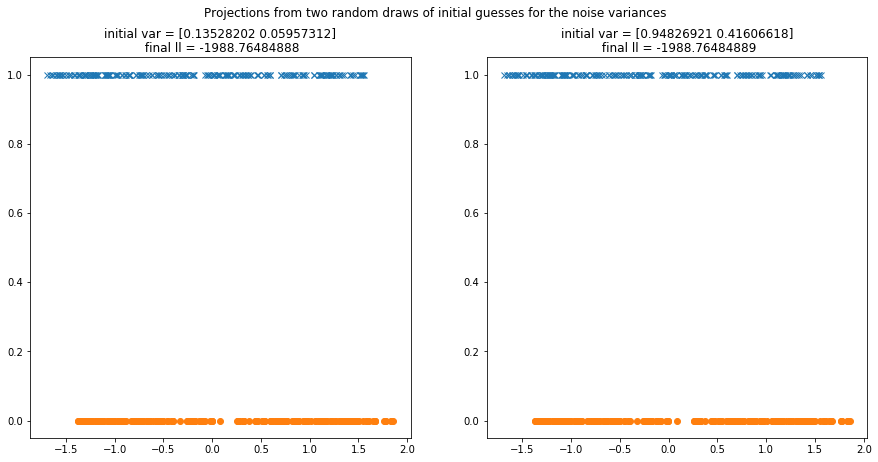

In [83]:
#transformer = FactorAnalysis(n_components=1, random_state=0)
plt.figure(figsize=(15,7))
plt.subplot(121) 
plt.suptitle("Projections from two random draws of initial guesses for the noise variances")

var_init = np.random.rand(params_size)[size_f+x_dim:size_f+x_dim*2]
plt.title("initial var = {}\n final ll = {}".format(var_init, transformer1.loglike_[-1]))
transformer1 = FactorAnalysis(n_components=1, random_state=0, noise_variance_init = var_init)

x_proj_scikit_1 = transformer1.fit_transform(x)
plt.plot(x_proj_scikit_1[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_scikit_1[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.subplot(122) 

var_init = np.random.rand(params_size)[size_f+x_dim:size_f+x_dim*2]
plt.title("initial var = {}\n final ll = {}".format(var_init, transformer2.loglike_[-1]))
transformer2 = FactorAnalysis(n_components=1, random_state=0, noise_variance_init = var_init)

x_proj_fa_scikit_2 = transformer2.fit_transform(x)
plt.plot(x_proj_fa_scikit_2[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_fa_scikit_2[n_samples_class:,0], np.zeros(n_samples_class), 'o')

plt.show()
print "F1:", transformer1.components_
print "var1:",transformer1.noise_variance_

print "F2:",transformer2.components_
print "var2:",transformer2.noise_variance_